In [1]:
from __future__ import print_function

import numpy as np
from sklearn import datasets, neighbors, linear_model, tree
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris, fetch_olivetti_faces
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import RandomizedPCA
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

1. K-nearest neighbors classification
======================


Prepare dataset
--------------
First we will prepare the dataset. The dataset we choose is a modified  version of the [Iris dataset](https://archive.ics.uci.edu/ml/datasets/Iris). We choose only the first two input feature dimensions viz _sepal-length_ and _sepal-width_ (both in cm) for ease of visualization. 

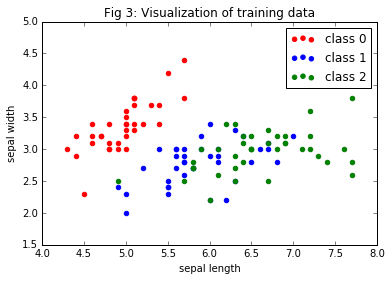

In [2]:
iris = load_iris()
X = iris.data[:,:2] #Choosing only the first two input-features
Y = iris.target

number_of_samples = len(Y)

#Splitting into training and test sets
random_indices = np.random.permutation(number_of_samples)
#Training set
num_training_samples = int(number_of_samples*0.75)
x_train = X[random_indices[:num_training_samples]]
y_train = Y[random_indices[:num_training_samples]]
#Test set
x_test = X[random_indices[num_training_samples:]]
y_test = Y[random_indices[num_training_samples:]]

#Visualizing the training data
X_class0 = np.asmatrix([x_train[i] for i in range(len(x_train)) if y_train[i]==0]) #Picking only the first two classes
Y_class0 = np.zeros((X_class0.shape[0]),dtype=np.int)
X_class1 = np.asmatrix([x_train[i] for i in range(len(x_train)) if y_train[i]==1])
Y_class1 = np.ones((X_class1.shape[0]),dtype=np.int)
X_class2 = np.asmatrix([x_train[i] for i in range(len(x_train)) if y_train[i]==2])
Y_class2 = np.full((X_class2.shape[0]),fill_value=2,dtype=np.int)

plt.scatter(X_class0[:,0], X_class0[:,1],color='red')
plt.scatter(X_class1[:,0], X_class1[:,1],color='blue')
plt.scatter(X_class2[:,0], X_class2[:,1],color='green')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend(['class 0','class 1','class 2'])
plt.title('Fig 3: Visualization of training data')
plt.show()

Note that the first class is linearly separable from the other two classes but the second and third classes are not linearly separable from each other.

K-nearest neighbour classifier algorithm
--------------------
Now that our training data is ready we will jump right into the classification task. Just to remind you, the K-nearest neighbor is a non-parametric learning algorithm and does not learn an parameterized function that maps the input to the output. Rather it looks up the training set every time it is asked to classify a point and finds out the K nearest neighbors of the query point. The class corresponding to majority of the points is output as the class of the query point.

In [3]:
model = neighbors.KNeighborsClassifier(n_neighbors = 5) # K = 5
model.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Visualize the working of the algorithm
-------------------------------
Let's see how the algorithm works.
We choose the first point in the test set as our query point.

In [4]:
query_point = np.array([5.9,2.9])
true_class_of_query_point = 1
predicted_class_for_query_point = model.predict([query_point])
print("Query point: {}".format(query_point))
print("True class of query point: {}".format(true_class_of_query_point))

Query point: [ 5.9  2.9]
True class of query point: 1


In [5]:
query_point.shape

(2,)

Let's visualize the point and its K=5 nearest neighbors.

The query point is: [ 5.9  2.9]

The nearest neighbors of the query point are:
 [[ 6.   2.9]
 [ 5.9  3. ]
 [ 5.9  3. ]
 [ 5.8  2.8]
 [ 6.1  2.9]]

The classes of the nearest neighbors are: [1 1 2 2 1]

Predicted class for query point: 1


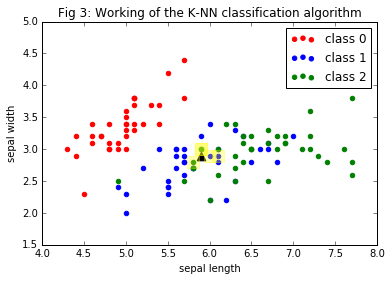

In [6]:
neighbors_object = neighbors.NearestNeighbors(n_neighbors=5)
neighbors_object.fit(x_train)
distances_of_nearest_neighbors, indices_of_nearest_neighbors_of_query_point = neighbors_object.kneighbors([query_point])
nearest_neighbors_of_query_point = x_train[indices_of_nearest_neighbors_of_query_point[0]]
print("The query point is: {}\n".format(query_point))
print("The nearest neighbors of the query point are:\n {}\n".format(nearest_neighbors_of_query_point))
print("The classes of the nearest neighbors are: {}\n".format(y_train[indices_of_nearest_neighbors_of_query_point[0]]))
print("Predicted class for query point: {}".format(predicted_class_for_query_point[0]))

plt.scatter(X_class0[:,0], X_class0[:,1],color='red')
plt.scatter(X_class1[:,0], X_class1[:,1],color='blue')
plt.scatter(X_class2[:,0], X_class2[:,1],color='green')
plt.scatter(query_point[0], query_point[1],marker='^',s=75,color='black')
plt.scatter(nearest_neighbors_of_query_point[:,0], nearest_neighbors_of_query_point[:,1],marker='s',s=150,color='yellow',alpha=0.30)
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend(['class 0','class 1','class 2'])
plt.title('Fig 3: Working of the K-NN classification algorithm')
plt.show()

In [7]:
def evaluate_performance(model, x_test, y_test):
    test_set_predictions = [model.predict(x_test[i].reshape((1,len(x_test[i]))))[0] for i in range(x_test.shape[0])]
    test_misclassification_percentage = 0
    for i in range(len(test_set_predictions)):
        if test_set_predictions[i]!=y_test[i]:
            test_misclassification_percentage+=1
    test_misclassification_percentage *= 100/len(y_test)
    return test_misclassification_percentage

In [8]:
#Evaluate the performances on the validation and test sets
print("Evaluating K-NN classifier:")
test_err = evaluate_performance(model, x_test, y_test)
print('test misclassification percentage = {}%'.format(test_err))


Evaluating K-NN classifier:
test misclassification percentage = 16%


2. Principal Components Analysis
================================

In this section we will use PCA for face recognition.

Load dataset
-----------
We will use the [Olivetti Faces](http://scikit-learn.org/stable/datasets/olivetti_faces.html) dataset. It has 10 faces each of 40 persons as 64x64 images.

In [9]:
faces_data = fetch_olivetti_faces()

In [10]:
n_samples, height, width = faces_data.images.shape
X = faces_data.data
n_features = X.shape[1]
y = faces_data.target
n_classes = int(max(y)+1)

print("Number of samples: {}, \nHeight of each image: {}, \nWidth of each image: {}, \nNumber of input features: {},\nNumber of output classes: {}\n".format(n_samples,height,
                                        width,n_features,n_classes))

Number of samples: 400, 
Height of each image: 64, 
Width of each image: 64, 
Number of input features: 4096,
Number of output classes: 40



Shuffle the data randomly and make train and test splits
--------------------------------------------------------

In [11]:
# Split into a training set (75%) and a test set (25%) 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

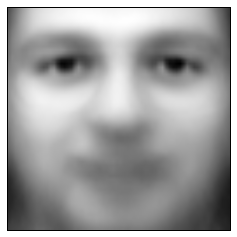

In [12]:
mean_image = np.mean(X_train,axis=0)
plt.figure
plt.imshow(mean_image.reshape((64,64)), cmap=plt.cm.gray)
plt.xticks(())
plt.yticks(())
plt.show()

Make a function for visualization of the images as an album
-----------------------------------------------------------

In [13]:
def plot_gallery(images, h, w, titles=None, n_row=3, n_col=4):
    """
    Helper function to plot a gallery of portraits
    Taken from: http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html
    """
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        if titles != None:
            plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


Visualize some faces from the training set
-----------------------------------------

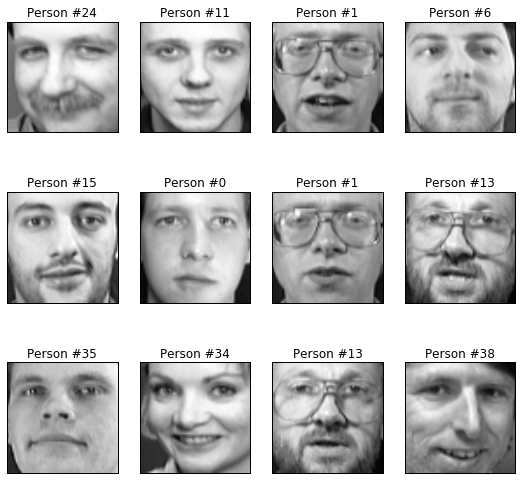

In [14]:

chosen_images = X_train[:12]
chosen_labels = y_train[:12]
titles = ['Person #'+str(i) for i in chosen_labels]

plot_gallery(chosen_images, height, width, titles)

Calculate a set of eigen-faces 
-----------------------------
We find the eigen vectors corresponding to the biggest eigen values of the covariance matrix of the data. These eigen vectors are the directions along which the data shows maximum amount of variation. Each eigen vector can be considered as an eigen face. We can represent any image in the dataset as a linear combination of these eigen faces with minimum error. 

In [15]:
#Reduce the dimensionality of the feature space
n_components = 150

#Finding the top n_components principal components in the data
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)

#Find the eigen-vectors of the feature space
eigenfaces = pca.components_.reshape((n_components, height, width))


Visualize the eigen faces
-------------------------

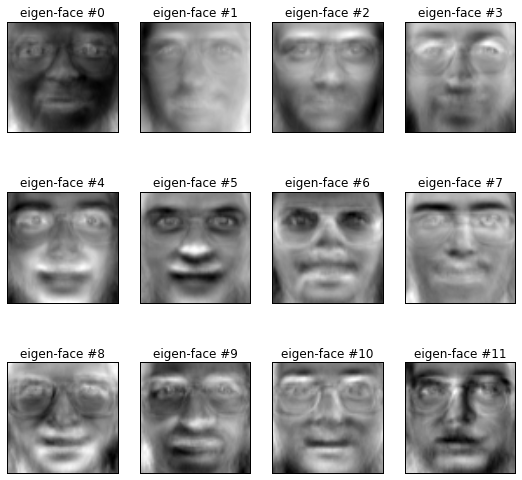

In [16]:
titles = ['eigen-face #'+str(i) for i in range(12)]
plot_gallery(eigenfaces, height, width, titles)

Transform the data to the vector space spanned by the eigen faces
-----------------------------------------------------------------

In [17]:
#Projecting the data onto the eigenspace
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("Current shape of input data matrix: ", X_train_pca.shape)

Current shape of input data matrix:  (300, 150)


Use a KNN-Classifier in this transformed space to identify the faces
------------------------------------------

In [19]:
knn_classifier = KNeighborsClassifier(n_neighbors = 5)
knn_classifier.fit(X_train_pca, y_train)

#Detect faces in the test set
y_pred_test = knn_classifier.predict(X_test_pca)
correct_count = 0.0
for i in range(len(y_test)):
    if y_pred_test[i] == y_test[i]:
        correct_count += 1.0
accuracy = correct_count/float(len(y_test))
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test, labels=range(n_classes)))

Accuracy: 0.55
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       0.00      0.00      0.00         2
          2       1.00      0.50      0.67         2
          3       0.00      0.00      0.00         4
          4       0.38      1.00      0.55         3
          5       0.75      1.00      0.86         3
          6       0.00      0.00      0.00         1
          7       1.00      0.57      0.73         7
          8       0.40      1.00      0.57         2
          9       0.75      1.00      0.86         3
         10       1.00      0.67      0.80         3
         11       1.00      0.25      0.40         4
         12       1.00      1.00      1.00         2
         13       1.00      1.00      1.00         1
         14       0.25      1.00      0.40         3
         15       1.00      0.50      0.67         2
         17       0.67      0.67      0.67         3
         18       0.67      1.

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)
target_names = [str(element) for element in np.arange(40)+1]
prediction_titles = [title(y_pred_test, y_test, target_names, i)
                     for i in range(y_pred_test.shape[0])]
plot_gallery(X_test, height, width, prediction_titles, n_row=2, n_col=6)
plt.show()